In [10]:
I_am = "yael" # change to yuval

if I_am == "yael":
    path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/" # to result sketches of the semantic simplification (to calculate the ratios) 
    path_to_files = "/home/vinker/dev/input_images/background_sketching/" # to input images
    path_to_source = "/home/vinker/dev/background_project/quantitative" # results of simplification axis, everything should be under this folder
    
    path_to_final_files = "/home/vinker/dev/input_images/quant_back_project_final/quantitative_clean_for_yael"

else: # change to your directories
    path_to_initial_sketches = "" # to result sketches of the semantic simplification (to calculate the ratios) 
    path_to_files = "" # to input images
    path_to_source = "" # results of simplification axis, everything should be under the same folder
    
# write your image names here
images_per_class = {"nature": ["assaf", "house3", "house4", "man_flowers", "yael"], 
                    "people": [], 
                    "urban": ["man_camera", "queen2", "woman_city"], 
                    "animals": ["bull", "cat_c", "dog"], 
                    "indoor": []}
layers = [2,7,8,11]

# Imports

In [8]:
import os
import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import sys 
import torch
import torch.nn as nn
from torchvision import models, transforms
import PIL
from skimage.transform import resize
import torch.nn.functional as F
import matplotlib.cm as cm
import shutil


p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage
from torchvision.utils import make_grid
from scipy.optimize import curve_fit

import notebooks_utils

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

# Utils

In [9]:
def ratios_to_str(ratios):
    ratios_str = ""
    for r_ in ratios:
        r_str = f"{r_:.3f}"
        ratios_str += f"{float(r_str)},"
    ratios_str = ratios_str[:-1]
    return ratios_str

def get_clip_loss(path, layer, object_or_background):
    path_config = f"{path}/config.npy"
    config = np.load(path_config, allow_pickle=True)[()]
    loss_clip = np.array(config[f"loss_eval"])
    best_iter = np.argsort(loss_clip)[0]
    loss_clip_layer = np.array(config[f"clip_vit_l{layer}_original_eval"])
    if object_or_background == "object":
        loss_clip_layer4 = np.array(config[f"clip_vit_l4_original_eval"])
        loss_clip_layer = 1*loss_clip_layer4 + loss_clip_layer
    return best_iter, loss_clip_layer

def func(x, a, c, d):
    return a*np.exp(c*x)

def func_inv(y,a,c,d):
    return np.log(y / a) * (1 / c)

def get_func(ratios_rel, start_x, start_ys):
    target_ys = ratios_rel[start_ys:]
    x = np.linspace(start_x, start_x + len(target_ys) - 1, len(target_ys))
    # calculate polynomial
    popt, pcov = curve_fit(func, x, target_ys, maxfev=3000)
    return popt

def get_ratios_srt2(path_to_initial_sketches, folder_name_l, layer, object_or_background, step_size_l, num_ratios=8):
    svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{folder_name_l}")
    seed = notebooks_utils.get_seed(svg_filename)
    path_li = f"{path_to_initial_sketches}/{folder_name_l}/{folder_name_l}_seed{seed}"
    best_iter, loss_clip_layer = get_clip_loss(path_li, layer, object_or_background)
    best_lclip_layer = loss_clip_layer[best_iter]
    r_1_k = 1 / best_lclip_layer
    
    # get the next ratios by jumping by 2
    r_j_k = r_1_k
    ratios_k = [r_1_k]
    for j in range(4):
        r_j_k = r_j_k / 2
        ratios_k.append(r_j_k)
    start_ys, start_x, end_x_addition = 0, 0, 0
    popt = get_func(ratios_k, start_x=0, start_ys=0) # fit the function to ratios_k
    # print(popt)
    # print(f"function :a*exp(c*x)")
    x_1_k = func_inv([r_1_k], *popt)

    step_size = step_size_l
    num_steps = num_ratios - start_x + end_x_addition
    start_ = x_1_k[0]
    end = num_steps * step_size
    # sample the function from the initial scaled r_1 with the corresponding step size
    new_xs_layer_l = np.linspace(start_, end - step_size + start_, num_steps) 
    # print("new_xs_layer_l", new_xs_layer_l)
    ratios_li = func(new_xs_layer_l, *popt)
    ratios_str = ratios_to_str(ratios_li)
    xs_layer_l_str = ratios_to_str(new_xs_layer_l)
    # print(f"layer {layer} r_1_k {r_1_k} \n new {ratios_str} \n x {xs_layer_l_str}\n")
    return ratios_str


def get_res_filename(im_name_, object_or_background, layer, resize_obj):
    im_name = im_name_
    if object_or_background == "background":
        im_name = f"{im_name_}_mask"
    res_filename = f"{object_or_background}_l{layer}_64s_{im_name}"
    if resize_obj:
        res_filename += f"_resize{resize_obj}"
    path_res = f"{path_to_initial_sketches}/{res_filename}"
    if not os.path.isdir(path_res):
        res_filename = f"{res_filename}_resize{resize_obj}"
    return res_filename


def get_res_filename_ratio(layer, im_name, min_div, resize_obj, r, path_to_res):
    test_name_pref = f"l{layer}_64s_{im_name}_{min_div}"
    if resize_obj:
        test_name_pref += f"_resize{resize_obj}"
    res_filename = f"ratio{r}_{test_name_pref}"
    path_res = f"{path_to_res}/{res_filename}"
    if not os.path.isdir(path_res):
        res_filename = f"{res_filename}_resize{resize_obj}"
    path_res = f"{path_to_res}/{res_filename}"
    if not os.path.isdir(path_res):
        test_name_pref = f"l{layer}_64s_{im_name}_{ablation_name_pref}"
        res_filename = f"ratio{r}_{test_name_pref}"
    return res_filename    

# Stroke count script

In [4]:
def get_strokes_count(object_or_background, resize_obj, im_name_, divs, layers):
    strokes_per_layer = {}
    im_name = im_name_
    if object_or_background == "background":
        im_name = f"{im_name_}_mask"
    for i, layer in enumerate(layers):
        strokes_per_layer[layer] = []
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        min_div = divs[i]
        ratios_org = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)        
        ratios = [float(item) for item in ratios_org.split(',')]
        for j, r in enumerate(ratios):
            res_filename = get_res_filename_ratio(layer, im_name, min_div, resize_obj, r, path_to_source)
            best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_source}/{res_filename}")
            path_svg = f"{path_to_source}/{res_filename}/{best_svg_filename}"
            canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(path_svg)
            strokes_count = 0
            for path in shapes:
                w = path.stroke_width / 1.5
                if w > 0.7:
                    strokes_count += 1
            strokes_per_layer[layer].append(strokes_count)
    return strokes_per_layer

def get_strokes_count_dict():
    strokes_per_image = {}
    for class_name in images_per_class.keys():
        print("=" * 10, class_name, "=" * 10)
        for im_name_ in images_per_class[class_name]:
            print("-" * 10, im_name_, "-" * 10)
            strokes_per_image[im_name_] = {}

            # background
            divs = [0.35, 0.45, 0.5, 0.9]
            object_or_background, resize_obj = "background", 0
            strokes_per_layer = get_strokes_count(object_or_background, resize_obj, im_name_, divs, layers)
            strokes_per_image[im_name_]["background"] = strokes_per_layer

            # object
            divs = [0.45,0.4,0.5,0.9]
            object_or_background, resize_obj = "object", 1
            strokes_per_layer = get_strokes_count(object_or_background, resize_obj, im_name_, divs, layers)
            strokes_per_image[im_name_]["object"] = strokes_per_layer
    return strokes_per_image

strokes_per_image = get_strokes_count_dict()

========== nature ==========
---------- assaf ----------


/home/miniconda/envs/habitat/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


---------- house3 ----------
---------- house4 ----------
---------- man_flowers ----------
---------- yael ----------
========== people ==========
========== urban ==========
---------- man_camera ----------
---------- queen2 ----------
---------- woman_city ----------
========== animals ==========
---------- bull ----------
---------- cat_c ----------
---------- dog ----------
========== indoor ==========


In [6]:
np.save("all.npy", strokes_per_image)

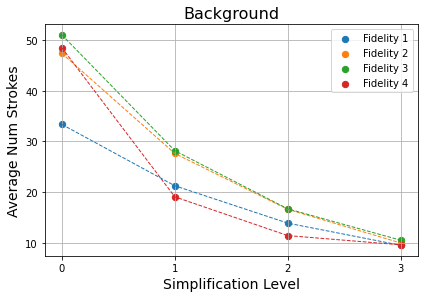

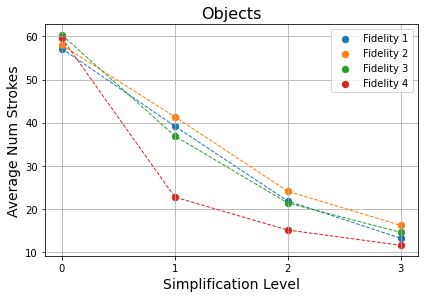

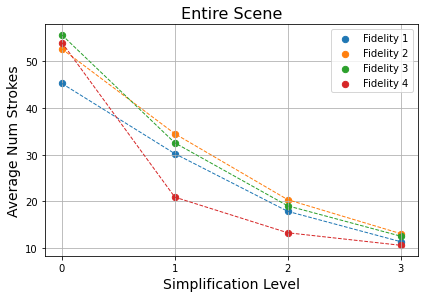

In [5]:
# analyse the results and plot the graph

def get_avg_stroke_count(object_or_background):
    strokes_count_avg = {}
    for l in layers:
        strokes_count_avg[l] = np.zeros(8)
    for im_name in strokes_per_image.keys():
        s_count = strokes_per_image[im_name][object_or_background]
        for l in layers:
            strokes_count_avg[l] += (np.array(s_count[l]) / len(strokes_per_image.keys()))
    return strokes_count_avg

def plot_num_strokes(strokes_count_avg, step=1, title=""):
    ylabel = "Average Num Strokes"
    xlabel = "Simplification Level"
    for i, l in enumerate(strokes_count_avg.keys()):
        num_s = strokes_count_avg[l][::step]
        plt.plot(range(len(num_s)), num_s, linewidth=1, ls="--")
        plt.scatter(range(len(num_s)), num_s, label=f"Fidelity {i + 1}", s=40)
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    # plt.title("Avg. Number of Strokes", fontsize=18)
    plt.xticks(range(len(num_s)))
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.title(title, fontsize=16)
    plt.show()

strokes_count_avg_b = get_avg_stroke_count("background")
plot_num_strokes(strokes_count_avg_b, step=2, title="Background")

strokes_count_avg_o = get_avg_stroke_count("object")
plot_num_strokes(strokes_count_avg_o, step=2, title="Objects")

strokes_count_avg_all = {}
for l in strokes_count_avg_b.keys():
    strokes_count_avg_all[l] = (strokes_count_avg_b[l] + strokes_count_avg_o[l]) / 2

plot_num_strokes(strokes_count_avg_all, step=2, title="Entire Scene")

# MS-SSIM for fidelity evaluation

In [42]:
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

class XDoG_(object):
    def __init__(self):
        super(XDoG_, self).__init__()
        self.gamma=0.98
        self.phi=200
        self.eps=-0.1
        self.sigma=0.8
        self.binarize=True
        
    def __call__(self, im, k=10):
        if im.shape[2] == 3:
            im = rgb2gray(im)
        imf1 = gaussian_filter(im, self.sigma)
        imf2 = gaussian_filter(im, self.sigma * k)
        imdiff = imf1 - self.gamma * imf2
        imdiff = (imdiff < self.eps) * 1.0  + (imdiff >= self.eps) * (1.0 + np.tanh(self.phi * imdiff))
        imdiff -= imdiff.min()
        imdiff /= imdiff.max()
        if self.binarize:
            th = threshold_otsu(imdiff)
            imdiff = imdiff >= th
        imdiff = imdiff.astype('float32')
        return imdiff

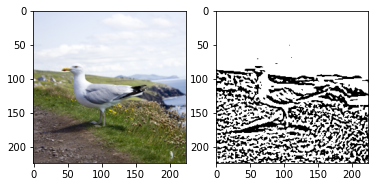

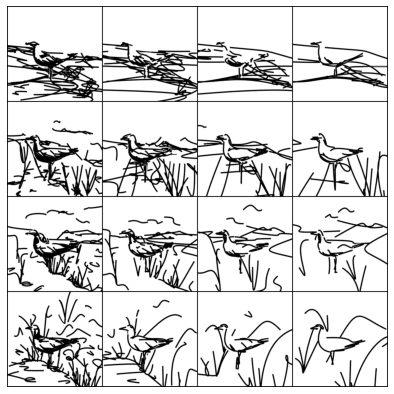

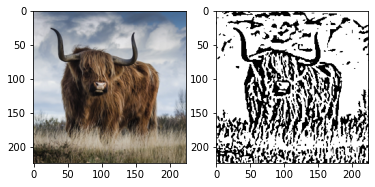

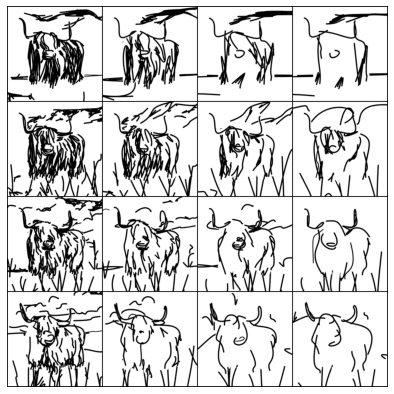

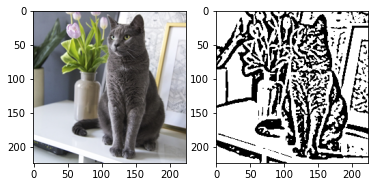

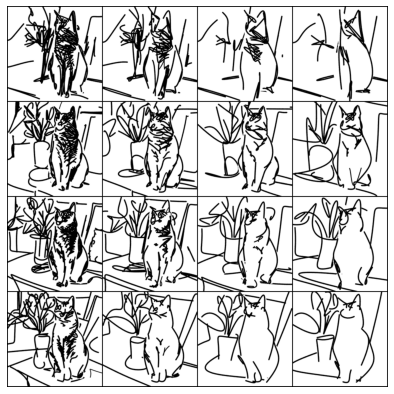

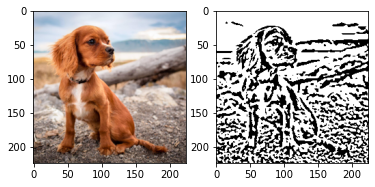

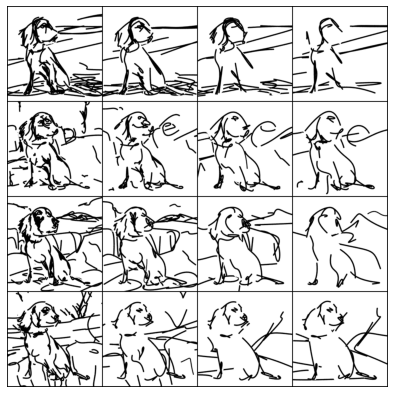

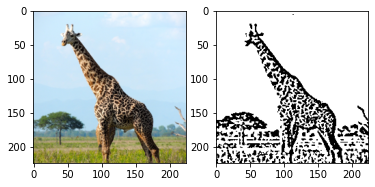

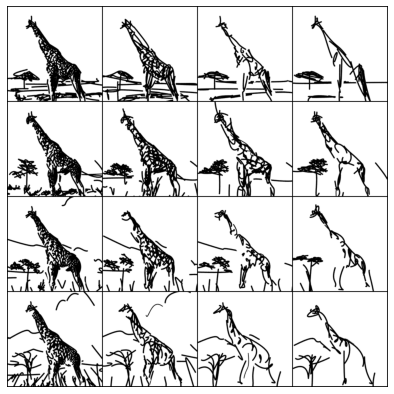

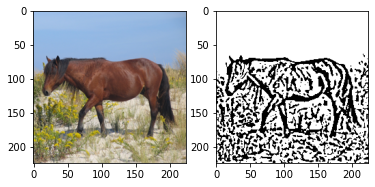

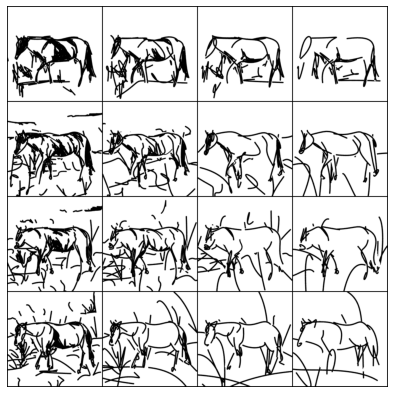

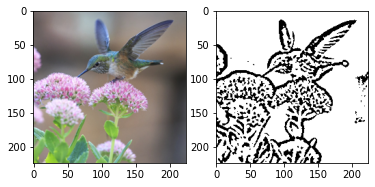

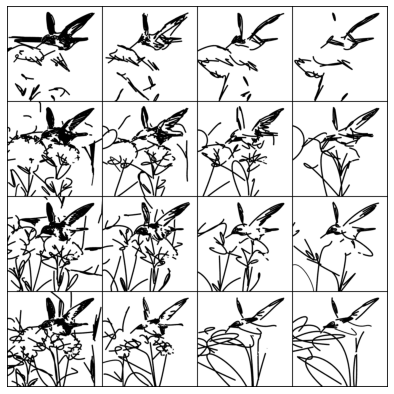

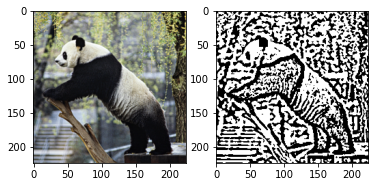

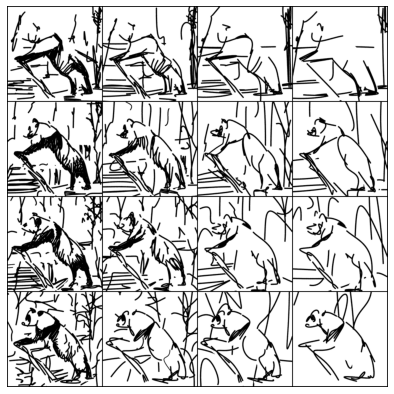

In [217]:
import torchvision
from torchmetrics import MultiScaleStructuralSimilarityIndexMeasure
from torchmetrics import StructuralSimilarityIndexMeasure


def get_matrix_distnce_per_image(images_per_class, display=False):
    dist_dict = {}
    xdog = XDoG_()
    ms_ssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=1.0)
    # ms_ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
    # ms_ssim = nn.MSELoss()
    for class_ in images_per_class.keys():
        dist_dict[class_] = {}
        for im_name_ in images_per_class[class_]:
            # read the input image and perform xdog
            input_images_path = f"{path_to_final_files}/input_images/{im_name_}.jpg"
            image = Image.open(input_images_path).convert("RGB").resize((224, 224))
            image_np = np.array(image) / 255
            im_xdog = xdog(image_np, k=3)
            if display:
                plt.subplot(1,2,1)
                plt.imshow(image)
                plt.subplot(1,2,2)
                plt.imshow(im_xdog, cmap="gray")
                plt.show()
            
            # read the sketches
            path_to_sketches = f"{path_to_final_files}/{class_}/{im_name_}"
            sketches_names = sorted(os.listdir(path_to_sketches))
            sketches = []
            for s_ in sketches_names:
                sketch = Image.open(f"{path_to_sketches}/{s_}").convert("RGB").resize((224, 224))
                sketch = np.array(sketch) / 255
                sketches.append(sketch)
            sketches_tensor = torch.Tensor(np.array(sketches)).permute(0,3,1,2)[:,0,:,:].unsqueeze(1)
            if display:
                grid_img = torchvision.utils.make_grid(sketches_tensor, nrow=4)
                plt.figure(figsize=(7,7))
                plt.imshow(grid_img.permute(1, 2, 0), cmap="gray")
                plt.axis("off")
                plt.show()
                plt.close()
            
            # calc distnace
            ms_ssim_dist_matrix = np.zeros((4,4))
            torch_xdog = torch.Tensor(im_xdog).unsqueeze(0).unsqueeze(0)
            for i in range(16):
                cur_sketch = sketches_tensor[i].unsqueeze(0)
                score = ms_ssim(cur_sketch, torch_xdog)
                ms_ssim_dist_matrix[i // 4, i % 4] = score
            dist_dict[class_][im_name_] = ms_ssim_dist_matrix
            # if display:
            #     plt.imshow(ms_ssim_dist_matrix)
            #     plt.axis("off")
            #     for i in range(4):
            #         for j in range(4):
            #             plt.text(j,i, "{:.3f}".format(ms_ssim_dist_matrix[i,j]), horizontalalignment='center', verticalalignment='center')
            #     plt.show()
    return dist_dict
           
def summarize_res(dist_dict):
    for class_ in dist_dict.keys():
        res_total_class = np.zeros(4)
        for im_name_ in dist_dict[class_]:
            res_total_class += dist_dict[class_][im_name_].mean(1)
        res_total_class /= len(dist_dict[class_].keys())
        
        res_str = ""
        for r_ in res_total_class:
            r_str = f"{r_:.3f}"
            res_str += f"{float(r_str)} & "
        print(class_, res_str)
    

images_per_class = {"nature": ["butterfly"]}#, "butterfly"]}
images_per_class = {
    # "people": ["baby", "ballerina", "black_man", "black_woman", "kid_hat", "man_camera", "royal_guard", "yael"],
    "urban": ["arc_de_triomphe", "bus", "eiffel_tower", "empire_building", "nyc", "queen", "traffic_light", "woman_city"],
    # "nature": ["boat", "butterfly", "house3", "house4", "lighthouse", "man_flowers", "mountain", "semi-complex_mask"],    
    # "indoor": ["bed", "book", "camera", "clock", "coffee_mug", "plant", "sofa", "womanhome"],
    # "indoor": ["coffee_mug"],
    # "animals": ["bird", "bull", "cat", "dog", "giraffe", "horse", "hummingbird", "panda"],    
}

images_per_class = {
    # "people": ["baby", "ballerina", "black_man", "black_woman", "kid_hat", "man_camera", "royal_guard", "yael"],
    # "urban": ["arc_de_triomphe", "eiffel_tower", "queen", "traffic_light"],
    # "nature": ["boat", "butterfly", "house3", "house4", "lighthouse", "man_flowers", "mountain", "semi-complex_mask"],    
    # "indoor": ["bed", "book", "camera", "clock", "coffee_mug", "plant", "sofa", "womanhome"],
    # "indoor": ["coffee_mug"],
    "animals": ["bird", "bull", "cat", "dog", "giraffe", "horse", "hummingbird", "panda"],    
}
dist_dict = get_matrix_distnce_per_image(images_per_class, display=True)
# summarize_res(dist_dict)

        
# (2) read the jpg image and calc xdog
# (3) calc distance matrix and display by fidelity



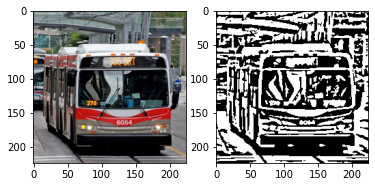

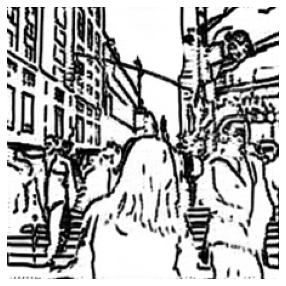

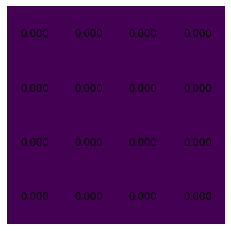

In [198]:
import torchvision
from torchmetrics import MultiScaleStructuralSimilarityIndexMeasure

def get_matrix_distnce_per_image(images_per_class, display=False):
    dist_dict = {}
    xdog = XDoG_()
    ms_ssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=1.0)
    for class_ in images_per_class.keys():
        dist_dict[class_] = {}
        for im_name_ in images_per_class[class_]:
            # read the input image and perform xdog
            input_images_path = f"{path_to_final_files}/input_images/{im_name_}.jpg"
            image = Image.open(input_images_path).convert("RGB").resize((224, 224))
            image_np = np.array(image) / 255
            im_xdog = xdog(image_np, k=5)
            if display:
                plt.subplot(1,2,1)
                plt.imshow(image)
                plt.subplot(1,2,2)
                plt.imshow(im_xdog, cmap="gray")
                plt.show()
            
            # # read the sketches
            # path_to_sketches = f"{path_to_final_files}/{class_}/{im_name_}"
            # sketches_names = sorted(os.listdir(path_to_sketches))
            # sketches = []
            # for s_ in sketches_names:
            #     sketch = Image.open(f"{path_to_sketches}/{s_}").convert("RGB").resize((224, 224))
            #     sketch = np.array(sketch) / 255
            #     sketches.append(sketch)
            path_to_sketches = "/home/vinker/dev/input_images/quant_back_project_final/quantitative_clean_for_yael/woman_city_out.png"
            sketch = Image.open(f"{path_to_sketches}").convert("RGB").resize((224, 224))
            sketch = np.array(sketch) / 255
            sketches = [sketch]
            
            sketches_tensor = torch.Tensor(np.array(sketches)).permute(0,3,1,2)[:,0,:,:].unsqueeze(1)
            if display:
                grid_img = torchvision.utils.make_grid(sketches_tensor, nrow=4)
                plt.figure(figsize=(5,5))
                plt.imshow(grid_img.permute(1, 2, 0), cmap="gray")
                plt.axis("off")
                plt.show()
                plt.close()
            
            # calc distnace
            ms_ssim_dist_matrix = np.zeros((4,4))
            torch_xdog = torch.Tensor(im_xdog).unsqueeze(0).unsqueeze(0)
            for i in range(sketches_tensor.shape[0]):
                cur_sketch = sketches_tensor[i].unsqueeze(0)
                score = ms_ssim(cur_sketch, torch_xdog)
                ms_ssim_dist_matrix[i // 4, i % 4] = score
            dist_dict[class_][im_name_] = ms_ssim_dist_matrix
            if display:
                plt.imshow(ms_ssim_dist_matrix)
                plt.axis("off")
                for i in range(4):
                    for j in range(4):
                        plt.text(j,i, "{:.3f}".format(ms_ssim_dist_matrix[i,j]), horizontalalignment='center', verticalalignment='center')
                plt.show()
    return dist_dict
           
def summarize_res(dist_dict):
    for class_ in dist_dict.keys():
        res_total_class = np.zeros(4)
        for im_name_ in dist_dict[class_]:
            res_total_class += dist_dict[class_][im_name_].mean(1)
        res_total_class /= len(dist_dict[class_].keys())
        print(class_, res_total_class)
    

images_per_class = {"nature": ["butterfly"]}#, "butterfly"]}
images_per_class = {
    # "people": ["baby", "ballerina", "black_man", "black_woman", "kid_hat", "man_camera", "royal_guard", "yael"],
    "urban": ["bus"],
    # "nature": ["boat", "butterfly", "house3", "house4", "lighthouse", "man_flowers", "mountain", "semi-complex_mask"],    
    # "indoor": ["bed", "book", "camera", "clock", "coffee_mug", "plant", "sofa", "womanhome"],
    # "animals": ["bird", "bull", "cat", "dog", "giraffe", "horse", "hummingbird", "panda"],    
}
dist_dict = get_matrix_distnce_per_image(images_per_class, display=True)
# summarize_res(dist_dict)

        
# (2) read the jpg image and calc xdog
# (3) calc distance matrix and display by fidelity


In [174]:
# display the results
print(dist_dict)

{'nature': {'butterfly': array([[0.31941652, 0.29641283, 0.3098028 , 0.29289788],
       [0.20406574, 0.17685187, 0.15778065, 0.16348818],
       [0.13941059, 0.15036866, 0.12319871, 0.15989938],
       [0.        , 0.1322398 , 0.11659542, 0.11577101]])}}


In [168]:
a = np.zeros((4,4))
k = 0
for i in range(4):
    for j in range(4):
        a[i,j] = k
        k += 1
print(a)
print(a.sum(1))

[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]]
[ 6. 22. 38. 54.]


In [142]:
# change names
# def get_rep_dict(image_name):
#     k=0
#     dict_rep = {}
#     for col in range(4):
#         for row in range(4):
#             dict_rep[f"{image_name}_row{row}col{col}_black.png"] = f"{image_name}_{k:02d}.png"
#             k+=1
#     return dict_rep

# def get_rep_dict(image_name):
#     k=0
#     dict_rep = {}
#     for l in [2,7,8,11]:
#         for i in range(4):
#             dict_rep[f"l{l}{image_name}_abs{i}.png"] = f"{image_name}_{k:02d}.png"
#             k+=1
#     return dict_rep
def get_rep_dict(image_name, image_paths):
    dict_rep = {}
    k=0
    for layer in [2, 7, 8, 11]:
        layer_paths = [path for path in image_paths if f"l{layer}" in f"_{str(path)}_"]
        # print(layer_paths)
        sorted_layer_paths = sorted(layer_paths, key=lambda x: float(x.split("_")[0].replace("ratio", "")),
                                    reverse=True)
        # print(sorted_layer_paths)
        for p in sorted_layer_paths:
            dict_rep[p] = f"{image_name}_{k:02d}.png"
            k += 1
        # processed_paths.extend(layer_paths)
    return dict_rep

images_per_class = {"people": ["baby"]}#, "butterfly"]}
for class_ in images_per_class.keys():
    for im_name_ in images_per_class[class_]:
        # dict_rep = get_rep_dict(image_name, image_paths)#get_rep_dict(im_name_)
        # print(dict_rep)
        path_to_sketches = f"{path_to_final_files}/{class_}/{im_name_}"
        sketches_names = sorted(os.listdir(path_to_sketches))
        dict_rep = get_rep_dict(im_name_, sketches_names)
        print(dict_rep)
        for s_ in sketches_names:
            print(f"{path_to_sketches}/{s_}", f"{path_to_sketches}/{dict_rep[s_]}")
            os.rename(f"{path_to_sketches}/{s_}", f"{path_to_sketches}/{dict_rep[s_]}")
        #     new_s = s_.replace("bananas", "apples")
# 


{'ratio83.89_l2_64s_baby_0.45_resize1_seed1000_best.png': 'baby_00.png', 'ratio44.955_l2_64s_baby_0.45_resize1_seed0_best.png': 'baby_01.png', 'ratio24.091_l2_64s_baby_0.45_resize1_seed0_best.png': 'baby_02.png', 'ratio12.91_l2_64s_baby_0.45_resize1_seed0_best.png': 'baby_03.png', 'ratio66.782_l7_64s_baby_0.4_resize1_seed1000_best.png': 'baby_04.png', 'ratio38.356_l7_64s_baby_0.4_resize1_seed0_best.png': 'baby_05.png', 'ratio22.03_l7_64s_baby_0.4_resize1_seed0_best.png': 'baby_06.png', 'ratio12.653_l7_64s_baby_0.4_resize1_seed0_best.png': 'baby_07.png', 'ratio39.382_l8_64s_baby_0.5_resize1_seed0_best.png': 'baby_08.png', 'ratio19.691_l8_64s_baby_0.5_resize1_seed1000_best.png': 'baby_09.png', 'ratio9.846_l8_64s_baby_0.5_resize1_seed0_best.png': 'baby_10.png', 'ratio4.923_l8_64s_baby_0.5_resize1_seed0_best.png': 'baby_11.png', 'ratio15.24_l11_64s_baby_0.9_resize1_seed1000_best.png': 'baby_12.png', 'ratio4.377_l11_64s_baby_0.9_resize1_seed1000_best.png': 'baby_13.png', 'ratio1.257_l11_64s

In [87]:
image_name = "house3"

print(dict_rep)

row0col0 00
row1col0 01
row2col0 02
row3col0 03
row0col1 04
row1col1 05
row2col1 06
row3col1 07
row0col2 08
row1col2 09
row2col2 10
row3col2 11
row0col3 12
row1col3 13
row2col3 14
row3col3 15
{'house3_row0col0_black.png': '00', 'house3_row1col0_black.png': '01', 'house3_row2col0_black.png': '02', 'house3_row3col0_black.png': '03', 'house3_row0col1_black.png': '04', 'house3_row1col1_black.png': '05', 'house3_row2col1_black.png': '06', 'house3_row3col1_black.png': '07', 'house3_row0col2_black.png': '08', 'house3_row1col2_black.png': '09', 'house3_row2col2_black.png': '10', 'house3_row3col2_black.png': '11', 'house3_row0col3_black.png': '12', 'house3_row1col3_black.png': '13', 'house3_row2col3_black.png': '14', 'house3_row3col3_black.png': '15'}


# Internal script for Yael to copy the files (Yuval - Ignore)

In [119]:
layers = [2, 7, 8, 11]

images = ["queen2"]
# panda
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_14_10"
output_path = "/home/vinker/dev/background_project/quantitative"
for im_name_ in images:
    print(im_name_)
    for i, layer in enumerate(layers):
        print(layer)
        # background
        divs = [0.35, 0.45, 0.5, 0.9]
        object_or_background, resize_obj, im_name = "background", 0, f"{im_name_}_mask"
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        min_div = divs[i]
        ratios_org = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)        
        ratios = [float(item) for item in ratios_org.split(',')]
        for j, r in enumerate(ratios):
            res_filename = get_res_filename_ratio(layer, im_name, min_div, resize_obj, r, path_to_res)
            if not os.path.exists(f"{output_path}/{res_filename}"):
                os.mkdir(f"{output_path}/{res_filename}")
            best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_res}/{res_filename}")
            path_best_im = f"{path_to_res}/{res_filename}/{best_svg_filename}"
            # print(path_best_im, f"{output_path}/{res_filename}/{best_svg_filename}")
            shutil.copyfile(path_best_im, f"{output_path}/{res_filename}/{best_svg_filename}")
            
            
        # object
        divs = [0.45,0.4,0.5,0.9]
        object_or_background, resize_obj, im_name = "object", 1, f"{im_name_}"
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        min_div = divs[i]
        ratios_org = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)        
        ratios = [float(item) for item in ratios_org.split(',')]
        for j, r in enumerate(ratios):
            res_filename = get_res_filename_ratio(layer, im_name, min_div, resize_obj, r, path_to_res)
            # print(res_filename)
            if not os.path.exists(f"{output_path}/{res_filename}"):
                os.mkdir(f"{output_path}/{res_filename}")
            best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_res}/{res_filename}")
            path_best_im = f"{path_to_res}/{res_filename}/{best_svg_filename}"
            # print(path_best_im, f"{output_path}/{res_filename}/{best_svg_filename}")
            shutil.copyfile(path_best_im, f"{output_path}/{res_filename}/{best_svg_filename}")
            

queen2
2
7
8
11
